In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [2]:
def generate_data(distrib,*args):
    return distrib(*args)
def mean(values, axis=None):
    """Function to use in bootstrap

    Parameters
    ----------
    values : data to average
    axis : axis or axes along which average
    Returns
    ----------
    mean : ndarray
        Average
    """
    if axis==None:
        return np.mean(values)
    else:
        return np.mean(values, axis=axis)
def resampling(values,B):
    """Creates B samples for the bootstrap (with replacements)
    
    Parameters
    ----------
    values : ndarray
        data to use 
    B : int
        number of samples needed
    Returns
    ----------
    x_resampled : ndarray
        array with dim0=B+1, contains the B samples and the original data in 
    the last position of the first axis (x_resampled[-1,:,:])
    
    """
    if B==1:
        return resample(values,replace=True)
    else:
        x_resampled = values
        x_resampled = np.expand_dims(x_resampled,axis=0)
        for i in range(B):
            x_resampled = np.insert(x_resampled,-1,resample(values,replace=True),axis=0)
        return x_resampled

### Statistics (mean and std) for the means and confidence interval obtained by bootstrap method for 100 different draws

In [5]:
import xarray as xr
import dask.array as da
import dask

In [8]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
#client = Client(cluster)
client= Client()
client

Client Scheduler: tcp://127.0.0.1:49366 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
#out.sel(stats='resmean').plot()
def bootstrap_stats(b, n, alpha=.05, mean=0., rms=0.1, Nexp=100):
    """
    Parameters
    
    b : int
        number of samples used for the bootstrap
    n : int
        size of the original data
    alpha : float
        confidence interval wanted
    xmean : float
        mean of the distribution
    xrms : float
        standard deviation of the distribution
    Nexp : int
        number of draws
    Returns
    
    out : ndarray
        mean and std average over the bootstrap, mean and std of lower band, mean and std of upper band
    """
    x = np.random.normal(mean, rms, size=(n, Nexp))
    X = xr.DataArray(resampling(x, b), dims=['bsample', 'points', 'experiments'])
    mean = X.mean(dim='points')
    q = mean.quantile([alpha,1-alpha], dim='bsample')
    lower = q.isel(quantile=0)
    upper = q.isel(quantile=1)
    return np.hstack([mean.mean(), mean.std(), 
                      lower.mean(),lower.std(), 
                      upper.mean(),upper.std()])

In [6]:
# create a delayed function
bootstrap_stats_delayed = dask.delayed(bootstrap_stats, pure=True)

In [9]:
b = np.arange(10,100,10) # bootstrap
df = np.arange(10,100,10) # degrees of freedom
Nexp = 5000
xmean = 0.
rms = 0.1
alpha = 0.1

lazy_data = [bootstrap_stats_delayed(_b, _n, alpha, mean=xmean, rms=rms, Nexp=Nexp) for _b in b for _n in df]
sample = lazy_data[0].compute()
arrays = [da.from_delayed(lazy_value,
                          dtype=sample.dtype,
                          shape=sample.shape)
          for lazy_value in lazy_data]

stack = (da.stack(arrays, axis=0)
         .reshape((len(b),len(df), sample.size))
        )

# HERE
stat_names = ['mean_mean', 'mean_rms', 
         'lower_mean', 'lower_rms', 
         'higher_mean', 'higher_rms']
_ds = (xr.DataArray(stack, dims=['b','df','stats'])
      .assign_coords(stats=stat_names,
                     b=b,
                     df=df)
     )

ds = xr.merge([_ds.sel(stats=s).drop('stats').rename(s) for s in stat_names]).persist()
ds

<xarray.Dataset>
Dimensions:      (b: 9, df: 9)
Coordinates:
  * b            (b) int64 10 20 30 40 50 60 70 80 90
  * df           (df) int64 10 20 30 40 50 60 70 80 90
Data variables:
    mean_mean    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    mean_rms     (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_mean   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_rms    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_mean  (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_rms   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>

In [10]:
from scipy.stats import norm
#xx = norm.pdf(X.mean(axis=1), loc=xmean, scale=xrms/np.sqrt(n))
def get_percentile(alpha, loc, rms, n):
    _p = lambda alpha: norm.ppf(alpha, loc=loc, 
                                scale=rms/np.sqrt(n))
    return _p(alpha), _p(1.-alpha)

th = get_percentile(alpha, xmean, rms, df)
# HERE
ds['lower_th'] = xr.DataArray(th[0], dims=['df'])
ds['upper_th'] = xr.DataArray(th[1], dims=['df'])

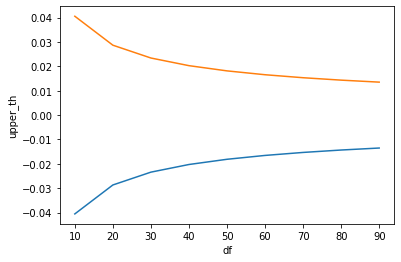

In [11]:
ds['lower_th'].plot()
ds['upper_th'].plot()

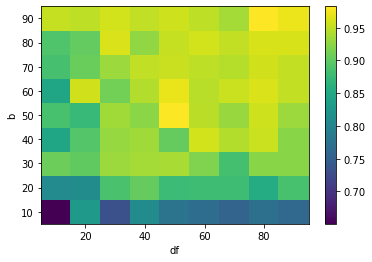

In [12]:
abs(ds['lower_mean']/ds['lower_th']).plot()

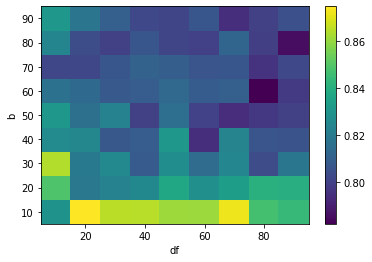

In [13]:
abs(ds['lower_rms']/ds['lower_th']).plot()

In [17]:
print(ds,th)

<xarray.Dataset>
Dimensions:      (b: 9, df: 9)
Coordinates:
  * df           (df) int64 10 20 30 40 50 60 70 80 90
  * b            (b) int64 10 20 30 40 50 60 70 80 90
Data variables:
    mean_mean    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    mean_rms     (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_mean   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_rms    (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_mean  (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    higher_rms   (b, df) float64 dask.array<chunksize=(1, 9), meta=np.ndarray>
    lower_th     (df) float64 -0.04053 -0.02866 -0.0234 ... -0.01433 -0.01351
    upper_th     (df) float64 0.04053 0.02866 0.0234 ... 0.01532 0.01433 0.01351 (array([-0.04052622, -0.02865636, -0.02339782, -0.02026311, -0.01812388,
       -0.01654476, -0.01531747, -0.01432818, -0.01350874]), array([0.04052622, 0.02865636, 0.02339782, 0.02

In [24]:
out = ds.compute()

In [71]:
bootl, booth = [],[]
vall,valh = [],[]
for i,n in enumerate(df):
    bootl.append(b[np.abs(ds.lower_mean.sel(df=n)-dsa
                          th[0][i]).argmin().values])
    booth.append(b[np.abs(out.sel(stats='higher_mean',df=n)-th[1][i]).argmin().values])
#    vall.append(out.sel(stats='lower_mean',df=n).where(out.sel(stats='lower_mean',df=n)==np.abs(out.sel(stats='lower_mean',df=n)-th[0][i]).min(),drop=True).values)
#    vall.append(out.sel(stats='lower_mean',df=n).where(out.sel(stats='higher_mean',df=n)==np.abs(out.sel(stats='higher_mean',df=n)-th[1][i]).min(),drop=True).values)

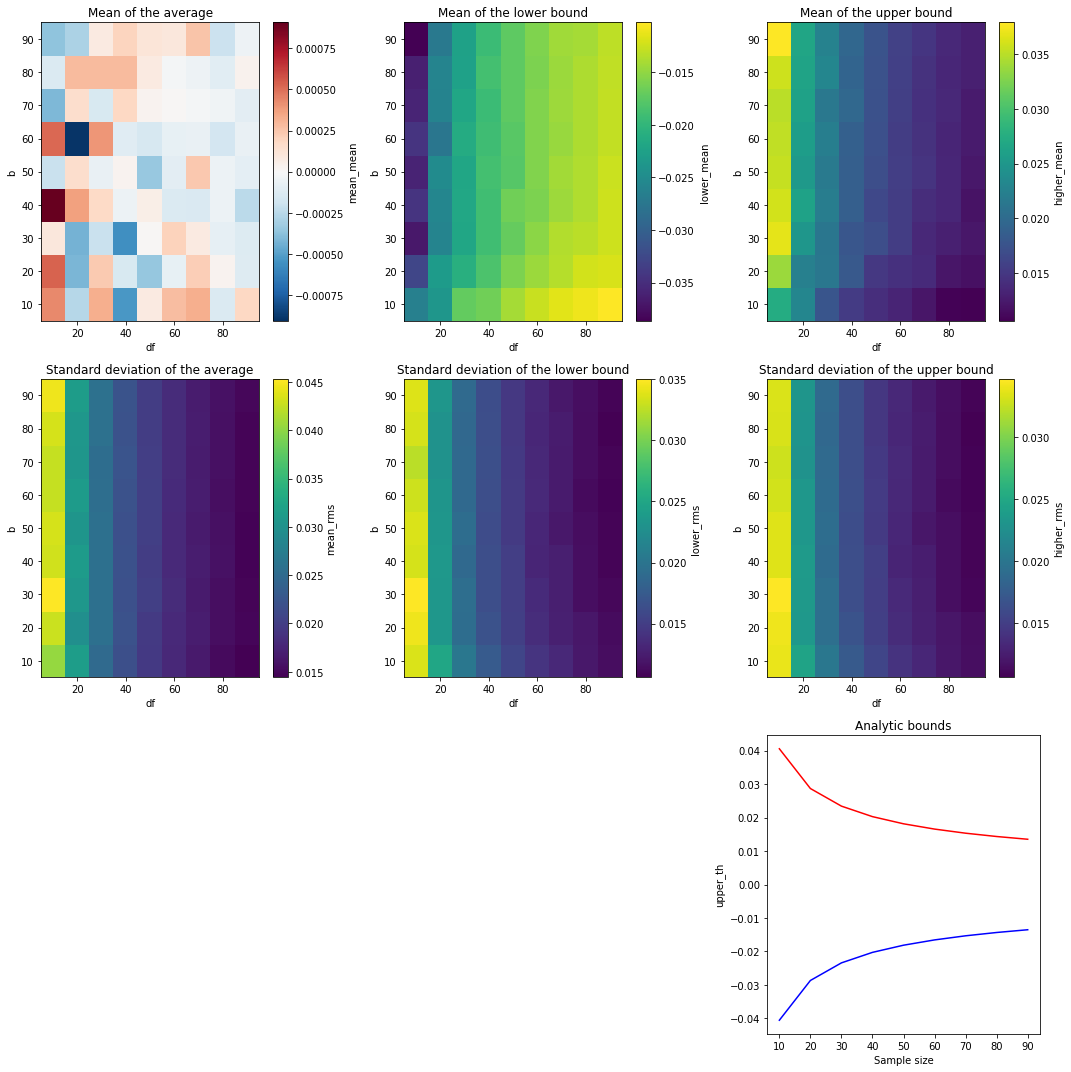

In [28]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(3,3,1)
ds.mean_mean.plot(ax=ax)
ax.set_title('Mean of the average')
ax = fig.add_subplot(3,3,4)
ds.mean_rms.plot(ax=ax)
ax.set_title('Standard deviation of the average')
ax = fig.add_subplot(3,3,2)
ds.lower_mean.plot(ax=ax)
ax.set_title('Mean of the lower bound')
#ax.scatter(df,bootl,c='r',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,5)
ds.lower_rms.plot(ax=ax)
ax.set_title('Standard deviation of the lower bound')
ax = fig.add_subplot(3,3,3)
ds.higher_mean.plot(ax=ax)
ax.set_title('Mean of the upper bound')
#ax.scatter(df,booth,c='b',label='Closer to analytic bound')
ax = fig.add_subplot(3,3,6)
ds.higher_rms.plot(ax=ax)
ax.set_title('Standard deviation of the upper bound')
ax = fig.add_subplot(3,3,9)
ds.lower_th.plot(c='b',ax=ax)
ds.upper_th.plot(c='r',ax=ax)
ax.set_title('Analytic bounds')
ax.set_xlabel('Sample size')

plt.tight_layout()

###  Normalized mean and rms

Text(0.5, 1.0, 'Normalized upper bound mean')

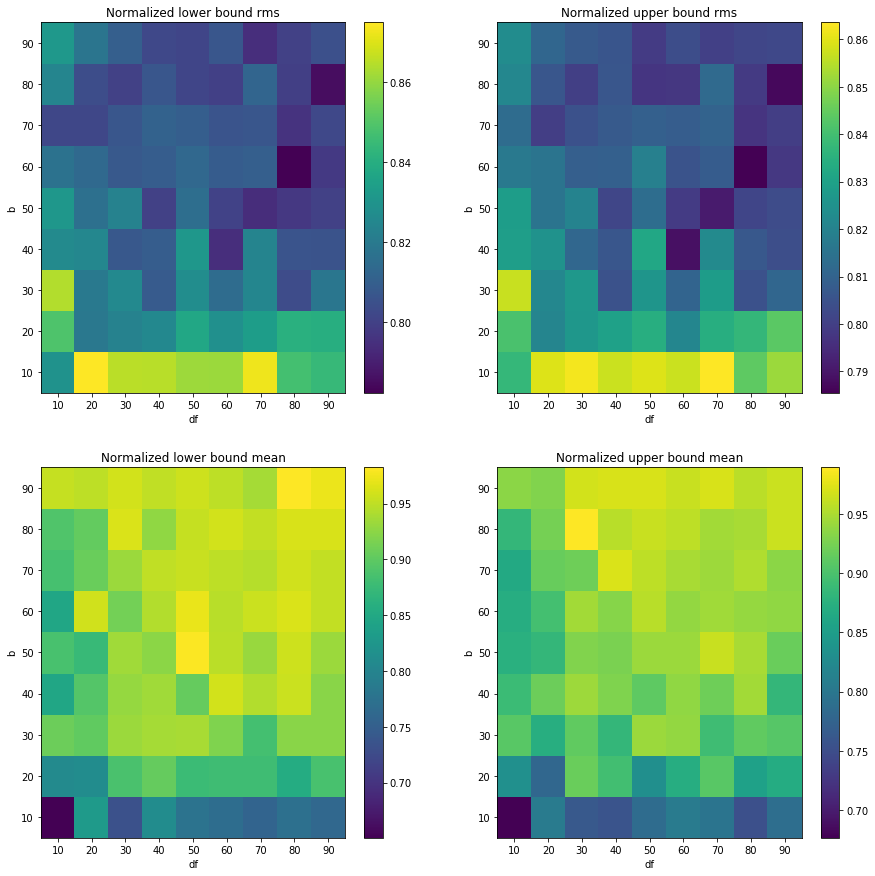

In [30]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(2,2,1)
abs(ds['lower_rms']/ds['lower_th']).plot(ax=ax)
ax.set_title('Normalized lower bound rms')
ax = fig.add_subplot(2,2,3)
abs(ds['lower_mean']/ds['lower_th']).plot(ax=ax)
ax.set_title('Normalized lower bound mean')
ax = fig.add_subplot(2,2,2)
abs(ds['higher_rms']/ds['upper_th']).plot(ax=ax)
ax.set_title('Normalized upper bound rms')
ax = fig.add_subplot(2,2,4)
abs(ds['higher_mean']/ds['upper_th']).plot(ax=ax)
ax.set_title('Normalized upper bound mean')

### 2D data:

In [ ]:
def bootstrap(values,B,stats,axis,t,*args_distrib):
    """Boostrap method
    
    Parameters
    ----------
    values : ndarray
        data or None if random generation of data following a specific distribution wanted
    idstri
    args_distrib : 
        args for chosen distribution
    B : int
        number of resampling
    stats : func 
        estimator (function to define)
    axis : int
        axis along which the stat function will be applied
    t : float
        parameter defining the confidence interval
    Returns
    ----------
    x_samples : ndarray
        array containing all the resampled data and the original data
    var : list
        variance computed using bootstrap method
    low : list
        lower bound of the confidence interval
    high : list
        upper bound of the confidence interval
    """
    x = np.random.normal(mean, rms, size=(n, Nexp))
    X = xr.DataArray(resampling(x, b), dims=['bsample', 'points', 'experiments'])
    mean = X.mean(dim='points')
    q = mean.quantile([alpha,1-alpha], dim='bsample')
    lower = q.isel(quantile=0)
    upper = q.isel(quantile=1)
    return np.hstack([mean.mean(), mean.std(), 
                      lower.mean(),lower.std(), 
                      upper.mean(),upper.std()])
    x_samples = resampling(values,B)
    n = stats(x_samples[-1,:,:],axis=axis).size
    means = mean(x_samples,axis+1)
    low = []
    high = []
    val = []
    p = ((1-t)/2) * 100
    p_ = ((1+t)/2) * 100
    for j in range(x_samples.shape[1]):
        _m = means[:,j]
        low.append(np.percentile(_m, p))
        high.append(np.percentile(_m, p_))
        val.append(_m[-1])
    return x_samples,val,low,high #x_samples, 1/B*var, 1/B*tst#1/B*tst

In [5]:
client.close()